## 통합 데이터 전처리 진행 

### 데이터 불러오기 및 병합 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# 데이터 불러오기 
df1 = pd.read_csv('../datasets/oliveyoung_wemake_data.csv', index_col= None)
df2 = pd.read_csv('../datasets/supplements_data_reviews.csv', index_col= None)
df1 = df1.drop(columns=['Unnamed: 0']) # 인덱스 열 삭제 
df2 = df2.drop(columns=['Unnamed: 0'])

In [3]:
# 병합 
data = pd.concat([df1, df2], axis=0)
data[:2]

,product_name,review_name,review_content,review_date,review_rating
0,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",보리오빠,없으면 안될 최고의 diet템! 피치번을 추천합니당 ㅎㅎ 사진엔 없지만 4통째 먹고...,2023.08.27,5점만점에 5점
1,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",바보바니,알약 통통이하트 넘예뻐요. 자기전 먹고 효과있으면 얼마나 좋을까요 ㅜㅜ 나이들수록 ...,2023.09.14,5점만점에 5점


### 전처리 진행

#### 결측치 처리 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7077 entries, 0 to 2487
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_name    7077 non-null   object
 1   review_name     7058 non-null   object
 2   review_content  6388 non-null   object
 3   review_date     6951 non-null   object
 4   review_rating   4423 non-null   object
dtypes: object(5)
memory usage: 331.7+ KB


In [5]:
data.isnull().sum()

product_name         0
review_name         19
review_content     689
review_date        126
review_rating     2654
dtype: int64

In [6]:
# 특정 컬럼 값의 결측치만 제거 
data.dropna(subset=['review_content'], inplace=True)

In [7]:
len(data) #데이터 갯수 확인

6388

#### 형태소 분석

In [8]:
from konlpy.tag import Okt
okt = Okt()

In [9]:
content = list(data['review_content']) # 하나로 뭉치기 #데이터타입 : list

In [10]:
sentence = ' '.join(content) #한줄로 만들기  #데이터 타입 : str

In [11]:
word_tokens = okt.morphs(sentence) #품사 분리 

In [12]:
#okt.pos(sentence) #품사 종류 보기 

In [13]:
# 리뷰내용 토큰화 함수 
def tokenize_sentence(sentence):
    tokens = okt.morphs(sentence)
    return ' '.join(tokens)

In [14]:
data['tokenized_review'] = data['review_content'].apply(tokenize_sentence)
data[:2]

,product_name,review_name,review_content,review_date,review_rating,tokenized_review
0,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",보리오빠,없으면 안될 최고의 diet템! 피치번을 추천합니당 ㅎㅎ 사진엔 없지만 4통째 먹고...,2023.08.27,5점만점에 5점,없으면 안될 최고 의 diet 템 ! 피치 번 을 추천 합니당 ㅎㅎ 사진 엔 없지만...
1,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",바보바니,알약 통통이하트 넘예뻐요. 자기전 먹고 효과있으면 얼마나 좋을까요 ㅜㅜ 나이들수록 ...,2023.09.14,5점만점에 5점,알약 통통이 하트 넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 ㅜㅜ 나이...


#### 유사어 대치 

In [15]:
replace_list = pd.read_csv('../datasets/replace_list.csv')
replace_list[:3]

,before_replacement,after_replacement
0,diet,다이어트
1,diet템,다이어트 제품
2,다욧트,다이어트


In [16]:
# 유사어 대치를 위한 함수 
def replace_word(tokenized_review):
    replaced_review = []
    for i in range(len(replace_list['before_replacement'])):
        try:
          # 치환할 단어가 있는 경우에만 데이터 치환 수행
          if isinstance(tokenized_review, str) and replace_list['before_replacement'][i] in tokenized_review:
            tokenized_review = tokenized_review.replace(replace_list['before_replacement'][i], replace_list['after_replacement'][i])
        except Exception as e:
            #print(f"Error 발생 / 에러명: {e}")
            pass
    return tokenized_review

In [17]:
# 확인용 
replace_word('diet템 stess 살이 빠지다 피치 달달 단맛 빨르다')

'다이어트 제품 스트레스 체중 빼다 복숭아 달달하다 달달하다 빠르다 '

In [18]:
data['replaced_review'] = data['tokenized_review'].apply(replace_word)
data[:2]

,product_name,review_name,review_content,review_date,review_rating,tokenized_review,replaced_review
0,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",보리오빠,없으면 안될 최고의 diet템! 피치번을 추천합니당 ㅎㅎ 사진엔 없지만 4통째 먹고...,2023.08.27,5점만점에 5점,없으면 안될 최고 의 diet 템 ! 피치 번 을 추천 합니당 ㅎㅎ 사진 엔 없지만...,없으면 안될 최고 의 다이어트 제품 ! 복숭아 번 을 추천 합니당 웃음 사진 엔 없...
1,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",바보바니,알약 통통이하트 넘예뻐요. 자기전 먹고 효과있으면 얼마나 좋을까요 ㅜㅜ 나이들수록 ...,2023.09.14,5점만점에 5점,알약 통통이 하트 넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 ㅜㅜ 나이...,알약 통통이 좋다넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 눈물눈물 나...


#### 불용어 처리/한글자 처리 

In [19]:
# 불용어 사전 불러오기
stop_words = pd.read_csv('../datasets/stopword_list.txt', header=None, encoding ='utf-8')
stop_words= stop_words[0].values

In [20]:
# 한글자 사전 불러오기 
one_char_keyword = pd.read_csv('../datasets/one_char_list.txt', header=None, encoding ='utf-8')
one_char_keyword = one_char_keyword[0].values

In [21]:
from konlpy.tag import Okt
okt = Okt()
from mecab import MeCab
mecab = MeCab()

In [22]:
# 불용어, 한글자 처리 함수
def remove_stopword(raw, pos=["Noun","Alpha","Verb","Number","Adjective"], stopword=stop_words):
    tokens = []
    for word, tag in okt.pos(
        raw, 
        norm=True,   # normalize 그랰ㅋㅏ -> 그래ㅋㅋ
        stem=True    # stemming 바뀌나->바뀌다
    ):
        if len(word) > 1 and tag in pos and word not in stopword:
            tokens.append(word)
        elif len(word) == 1 and word in list(one_char_keyword):
            tokens.append(word)
    return ' '.join(tokens)  # 결과 리스트를 문자열로 결합하여 반환

In [23]:
# 확인용 
test_sentence = "이 문장은 불용어 처리가 되어야 합니다. 가다 하다 있다 되다 먹다"
tokens_test = remove_stopword(test_sentence)
tokens_test

'문장 용어 처리'

In [24]:
data['preprocess_review'] = data['replaced_review'].apply(remove_stopword)
data[:2]

,product_name,review_name,review_content,review_date,review_rating,tokenized_review,replaced_review,preprocess_review
0,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",보리오빠,없으면 안될 최고의 diet템! 피치번을 추천합니당 ㅎㅎ 사진엔 없지만 4통째 먹고...,2023.08.27,5점만점에 5점,없으면 안될 최고 의 diet 템 ! 피치 번 을 추천 합니당 ㅎㅎ 사진 엔 없지만...,없으면 안될 최고 의 다이어트 제품 ! 복숭아 번 을 추천 합니당 웃음 사진 엔 없...,최고 다이어트 제품 복숭아 추천 웃음 사진 통째 찌다 필수 제품 버리다 제품 사랑 ...
1,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",바보바니,알약 통통이하트 넘예뻐요. 자기전 먹고 효과있으면 얼마나 좋을까요 ㅜㅜ 나이들수록 ...,2023.09.14,5점만점에 5점,알약 통통이 하트 넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 ㅜㅜ 나이...,알약 통통이 좋다넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 눈물눈물 나...,알약 통통이 좋다 예쁘다 효과 좋다 눈물 눈물 나이 빠지다 배 쌓이네 눈물 눈물 눈...


### 긍정/부정 댓글 분리 

In [25]:
import re

In [26]:
data['rating'] = data['review_rating'].str.extract(r'(\s\d(?=점))|(\d.\d)').apply(lambda x: ''.join(x.dropna()), axis=1)
data[:2]

,product_name,review_name,review_content,review_date,review_rating,tokenized_review,replaced_review,preprocess_review,rating
0,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",보리오빠,없으면 안될 최고의 diet템! 피치번을 추천합니당 ㅎㅎ 사진엔 없지만 4통째 먹고...,2023.08.27,5점만점에 5점,없으면 안될 최고 의 diet 템 ! 피치 번 을 추천 합니당 ㅎㅎ 사진 엔 없지만...,없으면 안될 최고 의 다이어트 제품 ! 복숭아 번 을 추천 합니당 웃음 사진 엔 없...,최고 다이어트 제품 복숭아 추천 웃음 사진 통째 찌다 필수 제품 버리다 제품 사랑 ...,5
1,"[주현영, 이나연 찐템]딥트 3일 피치(맛)번 30정 (30일분)",바보바니,알약 통통이하트 넘예뻐요. 자기전 먹고 효과있으면 얼마나 좋을까요 ㅜㅜ 나이들수록 ...,2023.09.14,5점만점에 5점,알약 통통이 하트 넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 ㅜㅜ 나이...,알약 통통이 좋다넘 예뻐요 . 자기전 먹고 효과 있으면 얼마나 좋을까요 눈물눈물 나...,알약 통통이 좋다 예쁘다 효과 좋다 눈물 눈물 나이 빠지다 배 쌓이네 눈물 눈물 눈...,5


In [27]:
# 'rating' 열을 숫자로 변환
data['rating'] = pd.to_numeric(data['rating'])

In [28]:
# 전처리 데이터 저장
data.to_csv('../datasets/preprocessed_total_data.csv', index=None)

In [29]:
condition_positive =  data['rating'] >= 4 # 긍정
condition_negative = data['rating'] <= 3  # 부정

In [30]:
review_positive = data[condition_positive]
review_negative= data[condition_negative]

In [31]:
# # 저장
# review_positive.to_csv('../datasets/review_positive.csv')
# review_negative.to_csv('../datasets/review_negative.csv')

## wordcloud

In [33]:
from wordcloud import WordCloud
from collections import Counter

In [40]:
combined_text = ' '.join(data['preprocess_review'])

In [42]:
text_regex_count = Counter(combined_text.split()) # list를 count

In [43]:
# 한글 폰트 경로 설정 (Windows 환경에 맞게 경로 수정)
font_path = 'C:/Windows/Fonts/malgun.ttf'

wordCloud = WordCloud(font_path=font_path, background_color='white') #인스턴스화 
wordCloud.generate_from_frequencies(text_regex_count)

In [44]:
# count 
wordCloud.words_ 

{'좋다': 1.0,
 '웃음': 0.5394407819959082,
 '맛': 0.5255739940895658,
 '제품': 0.4794271425323937,
 '구매': 0.47260741077517615,
 '효과': 0.3675835417140259,
 '눈물': 0.3023414412366447,
 '물': 0.2896112752898386,
 '편하다': 0.23959990907024323,
 '운동': 0.23664469197544896,
 '꾸준하다': 0.2309615821777677,
 '맛있다': 0.20709252102750625,
 '빠지다': 0.17754035007956354,
 '이르다': 0.1527619913616731,
 '생각': 0.15162536940213686,
 '화장실': 0.14935212548306434,
 '느낌': 0.14685155717208456,
 '하루': 0.14639690838827008,
 '알약': 0.14616958399636282,
 '섭취': 0.14548761082064104,
 '알': 0.14275971811775404,
 '체중': 0.14162309615821778,
 '도움': 0.13571266196862924,
 '배송': 0.13503068879290747,
 '후기': 0.1316208229142987,
 '크다': 0.1245737667651739,
 '가격': 0.12434644237326666,
 '젤리': 0.12389179358945215,
 '괜찮다': 0.11298022277790407,
 '몸': 0.11070697885883156,
 '주문': 0.103887247101614,
 '포': 0.0963855421686747,
 '추천': 0.09502159581723119,
 '보조': 0.09206637872243692,
 '포장': 0.09206637872243692,
 '빠르다': 0.09206637872243692,
 '구입': 0.09024778

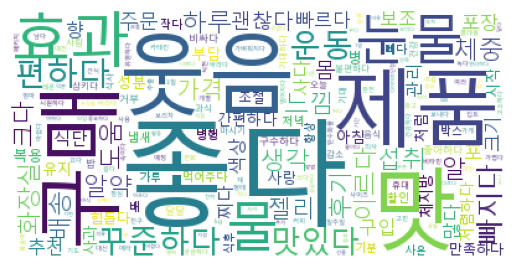

In [45]:
import matplotlib.pyplot as plt
plt.imshow(wordCloud)
plt.axis('off') 
plt.show()